In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
import cv2

In [3]:
def letter_img_resize(img, dst_size, stride=64, pad_color=(125, 125, 125)):
    """
    only scale down
    :param img:
    :param dst_size: int or [h, w]
    :param stride:
    :return:
    """
    if isinstance(dst_size, int):
        dst_size = [dst_size, dst_size]
        
    # 将dst_size调整到是stride的整数倍
    dst_del_h, dst_del_w = np.remainder(dst_size[0], stride), np.remainder(dst_size[1], stride)
    dst_pad_h = stride - dst_del_h if dst_del_h > 0 else 0
    dst_pad_w =  stride - dst_del_w if dst_del_w > 0 else 0
    dst_size = [dst_size[0] + dst_pad_h, dst_size[1] + dst_pad_w]
    
    org_h, org_w = img.shape[:2]  # [height, width]
    scale = np.min([dst_size[0] / org_w, dst_size[1] / org_h])
    scale = min(scale, 1.0)  # only scale down for good test performance
    resize_h, resize_w = int(org_h * scale), int(org_w * scale)
    img_resize = cv2.resize(img.copy(), (resize_w, resize_h), interpolation=0)
    
    pad_h, pad_w = dst_size[0] - resize_h, dst_size[1] - resize_w
    pad_h, pad_w = np.remainder(pad_h, stride), np.remainder(pad_w, stride)
    top = int(round(pad_h / 2))
    left = int(round(pad_w / 2))
    bottom = pad_h - top
    right = pad_w - left
    img_resize = cv2.copyMakeBorder(img_resize, top, bottom, left, right, cv2.BORDER_CONSTANT, value=tuple(pad_color))
    letter_info = {'scale': scale, 'pad_h': top, 'pad_w': left}
    return img_resize, letter_info

In [4]:
img1 = np.asarray(Image.open('/Users/ylj/Dataset/COCO/train2017/'+f'000000113588.jpg')).astype(np.uint8)
img1.shape

(640, 425, 3)

In [5]:
img, info = letter_img_resize(img1, 640)
img.shape

(640, 448, 3)

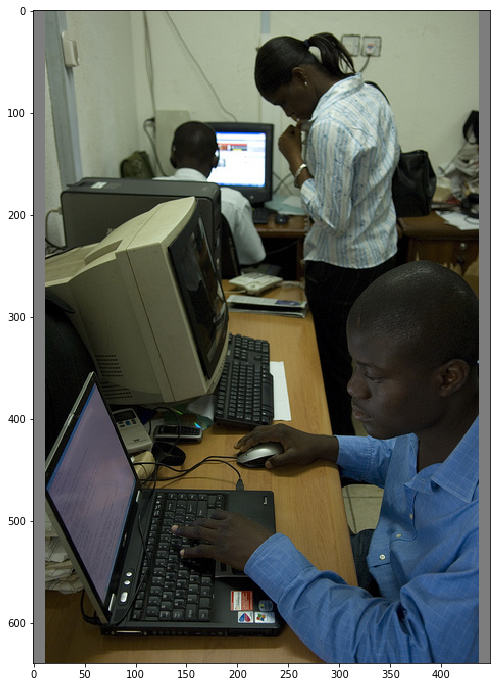

In [6]:
plt.figure(figsize=[12, 12])
plt.imshow(img)

In [7]:
info

{'scale': 1.0, 'pad_h': 0, 'pad_w': 12}

In [8]:

def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    print(dw, dh)
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [9]:
img2 = cv2.resize(img1, (300, 250))

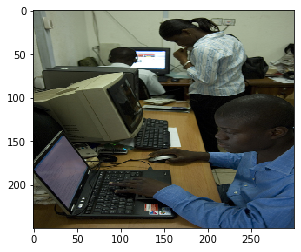

In [10]:
plt.imshow(img2)

In [11]:
res = letterbox(img2, scaleup=False)

340 390


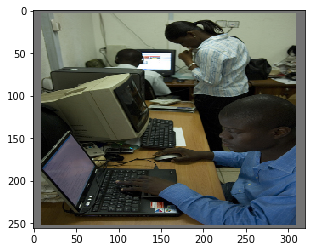

In [12]:
plt.imshow(res[0])

In [54]:
def letter_img_resize(img, dst_size, stride=64, fill_value=128, training=True):
    """
    only scale down
    :param fill_value:
    :param training:
    :param img:
    :param dst_size: int or [h, w]
    :param stride:
    :return:
    """
    if isinstance(dst_size, int):
        dst_size = [dst_size, dst_size]

    # 将dst_size调整到是stride的整数倍
    dst_del_h, dst_del_w = np.remainder(dst_size[0], stride), np.remainder(dst_size[1], stride)
    dst_pad_h = stride - dst_del_h if dst_del_h > 0 else 0
    dst_pad_w = stride - dst_del_w if dst_del_w > 0 else 0
    dst_size = [dst_size[0] + dst_pad_h, dst_size[1] + dst_pad_w]

    org_h, org_w = img.shape[:2]  # [height, width]
    scale = np.min([dst_size[0] / org_h, dst_size[1] / org_w])
    scale = min(scale, 1.0)  # only scale down for good test performance
    if scale != 1.:
        resize_h, resize_w = int(org_h * scale), int(org_w * scale)
        img_resize = cv2.resize(img.copy(), (resize_w, resize_h), interpolation=0)
    else:
        resize_h, resize_w = img.shape[:2]
        img_resize = img.copy()

    # 训练的时候需要一个batch保持固定的尺寸，而测试的时候尽可能的少填充像素以加速inference
    if not training:  
        pad_h, pad_w = dst_size[0] - resize_h, dst_size[1] - resize_w
        pad_h, pad_w = np.remainder(pad_h, stride), np.remainder(pad_w, stride)
        top = int(round(pad_h / 2))
        left = int(round(pad_w / 2))
        bottom = pad_h - top
        right = pad_w - left
        if isinstance(fill_value, int):
            fill_value = (fill_value, fill_value, fill_value)
        img_out = cv2.copyMakeBorder(img_resize, top, bottom, left, right, cv2.BORDER_CONSTANT, value=fill_value)
    else:
        img_out = np.full(shape=dst_size+[3], fill_value=fill_value)
        pad_h, pad_w = dst_size[0] - resize_h, dst_size[1] - resize_w
        top, left = pad_h // 2, pad_w // 2
        img_out[top:(top+resize_h), left:(left+resize_w)] = img_resize
    letter_info = {'scale': scale, 'pad_h': top, 'pad_w': left}
    return img_out, letter_info

(640, 425, 3)
(640, 448, 3)


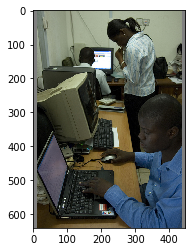

In [55]:
img = np.asarray(Image.open('/Users/ylj/Dataset/COCO/train2017/'+f'000000113588.jpg')).astype(np.uint8)
print(img.shape)
img, info = letter_img_resize(img, 640, training = False)
print(img.shape)
plt.imshow(img)